In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op='+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad += 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot    

In [4]:
# inputs x1, 2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

o.backward()

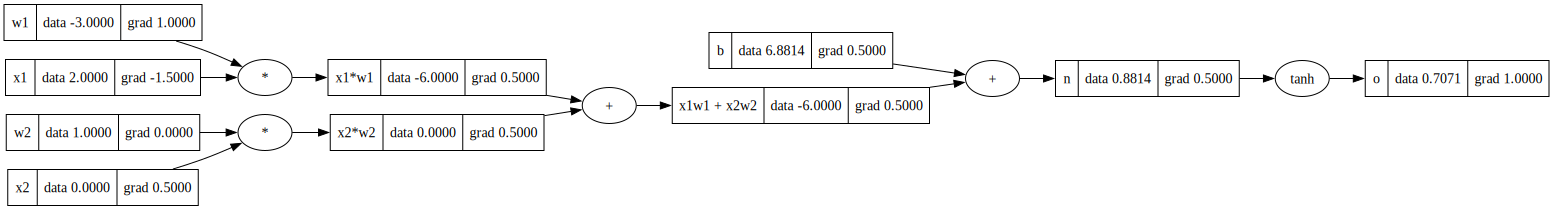

In [5]:
draw_dot(o)

In [6]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [7]:
import torch

In [8]:
x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True      
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True  
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True  
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [9]:
class Neuron:    
    def __init__(self, nin): #nin = Num inputs
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x): 
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return([p for neuron in self.neurons for p in neuron.parameters()])

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return([p for layer in self.layers for p in layer.parameters()])

In [10]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3620193278467456)

In [11]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [12]:
for k in range(100): 
    # forward pass
    ypred = [n(x) for x in xs]
    # mean squared loss (cross entropy loss used for predicting next token in LLMs)
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 5.368463370810218
1 3.5640345354255984
2 2.751661140055262
3 2.0097331942459316
4 1.3025152097413015
5 0.8125659314238526
6 0.5298691978071448
7 0.36466938277884997
8 0.26260019110942084
9 0.19679745950129224
10 0.15304765895058053
11 0.12309243867570757
12 0.10191959845385212
13 0.08645787878895839
14 0.07481165914275839
15 0.06579163965598879
16 0.058633555488120215
17 0.052832599478768116
18 0.048045912403143834
19 0.04403434960766353
20 0.040626955805717097
21 0.03769875988583542
22 0.03515654596166057
23 0.03292951267324891
24 0.030962999900304156
25 0.029214185124654676
26 0.027649072528742297
27 0.026240348145987018
28 0.024965826402288515
29 0.023807307711744503
30 0.0227497265048237
31 0.02178050760076953
32 0.02088907415215064
33 0.020066467304624087
34 0.019305049196697982
35 0.018598268833787273
36 0.01794047589531394
37 0.017326771442415043
38 0.016752887293192464
39 0.016215087860158406
40 0.015710089729061988
41 0.0152349953560834
42 0.014787238079900579
43 0.014364536

In [13]:
ypred

[Value(data=0.9613519814600862),
 Value(data=-0.9750665981135024),
 Value(data=-0.9652802973514677),
 Value(data=0.9540032730251112)]